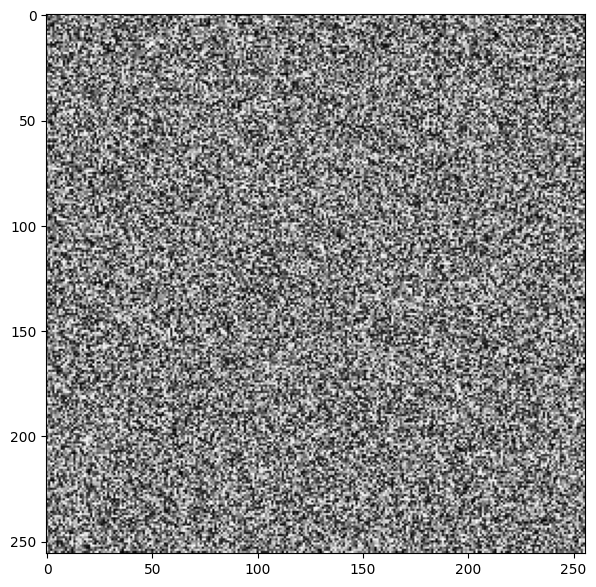

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# generate random numpy array with values from 0 to 255
# and a size of 256x256
random_image = np.random.randint(0, 256, (256, 256))
# initialize plot
plt.figure(figsize=(7, 7))
# show grayscale image, nb: cmap, vmin and vmax
plt.imshow(random_image, cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from tqdm import tqdm

def create_dataset(training_df, image_dir):
    """
    This function takes the training dataframe
    and outputs training array and labels
    :param training_df: dataframe with ImageId, Target columns
    :param image_dir: location of images (folder), string
    :return: X, y (training array with features and labels)
    """
    # create empty list to store image vectors
    images = []
    # create empty list to store targets
    targets = []
    # loop over the dataframe
    for index, row in tqdm(
        training_df.iterrows(),
        total=len(training_df),
        desc="processing images"
    ):
        # get image id
        image_id = row["ImageId"]
        # create image path
        image_path = os.path.join(image_dir, image_id)
        # open image using PIL
        image = Image.open(image_path + ".png")
        # resize image to 256x256. we use bilinear resampling
        image = image.resize((256, 256), resample=Image.BILINEAR)
        # convert image to array
        image = np.array(image)
        # ravel
        image = image.ravel()
        # append images and targets lists
        images.append(image)
        targets.append(int(row["target"]))
    # convert list of list of images to numpy array
    images = np.array(images)
    # print size of this array
    print(images.shape)
    return images, targets

if __name__ == "__main__":
    csv_path = "/home/abhishek/workspace/siim_png/train.csv"
    image_path = "/home/abhishek/workspace/siim_png/train_png/"
    # read CSV with imageid and target columns
    df = pd.read_csv(csv_path)
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1

    # the next step is to randomize the rows of the data
    df = df.sample(frac=1).reset_index(drop=True)

    # fetch labels
    y = df.target.values

    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)

    # fill the new kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f
    # we go over the folds created
    for fold_ in range(5):
        # temporary dataframes for train and test
        train_df = df[df.kfold != fold_].reset_index(drop=True)
        test_df = df[df.kfold == fold_].reset_index(drop=True)

        # create train dataset
        # you can move this outside to save some computation time
        xtrain, ytrain = create_dataset(train_df, image_path)
        # create test dataset
        # you can move this outside to save some computation time
        xtest, ytest = create_dataset(test_df, image_path)
        # fit random forest without any modification of params
        clf = ensemble.RandomForestClassifier(n_jobs=-1)
        clf.fit(xtrain, ytrain)
        # predict probability of class 1
        preds = clf.predict_proba(xtest)[:, 1]
        # print results
        print(f"FOLD: {fold_}")
        print(f"AUC = {metrics.roc_auc_score(ytest, preds)}")
        print("")


FileNotFoundError: [Errno 2] No such file or directory: '/home/abhishek/workspace/siim_png/train.csv'

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # convolution part
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=96,
            kernel_size=11,
            stride=4,
            padding=0
        )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=96,
            out_channels=256,
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(
            in_channels=256,
            out_channels=384,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv4 = nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv5 = nn.Conv2d(
            in_channels=384,
            out_channels=256,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        # dense part
        self.fc1 = nn.Linear(
            in_features=9216,
            out_features=4096
        )
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(
            in_features=4096,
            out_features=4096
        )
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(
            in_features=4096,
            out_features=1000
        )

    def forward(self, image):
        # get the batch size, channels, height and width
        # of the input batch of images
        # original size: (bs, 3, 227, 227)
        bs, c, h, w = image.size()
        x = F.relu(self.conv1(image))  # size: (bs, 96, 55, 55)
        x = self.pool1(x)  # size: (bs, 96, 27, 27)
        x = F.relu(self.conv2(x))  # size: (bs, 256, 27, 27)
        x = self.pool2(x)  # size: (bs, 256, 13, 13)
        x = F.relu(self.conv3(x))  # size: (bs, 384, 13, 13)
        x = F.relu(self.conv4(x))  # size: (bs, 384, 13, 13)
        x = F.relu(self.conv5(x))  # size: (bs, 256, 13, 13)
        x = self.pool3(x)  # size: (bs, 256, 6, 6)
        x = x.view(bs, -1)  # size: (bs, 9216)
        x = F.relu(self.fc1(x))  # size: (bs, 4096)
        x = self.dropout1(x)  # size: (bs, 4096)
        # dropout does not change size
        # dropout is used for regularization
        # 0.3 dropout means that only 70% of the nodes
        # of the current layer are used for the next layer
        x = F.relu(self.fc2(x))  # size: (bs, 4096)
        x = self.dropout2(x)  # size: (bs, 4096)
        x = F.relu(self.fc3(x))  # size: (bs, 1000)
        # 1000 is number of classes in ImageNet Dataset
        # softmax is an activation function that converts
        # linear output to probabilities that add up to 1
        # for each sample in the batch
        x = torch.softmax(x, axis=1)  # size: (bs, 1000)
        return x


In [7]:
# dataset.py
import torch
import numpy as np
from PIL import Image
from PIL import ImageFile

# Sometimes, you will have images without an ending bit
# This takes care of those kinds of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

class ClassificationDataset:
    """
    A general classification dataset class that you can use for all
    kinds of image classification problems. For example,
    binary classification, multi-class, multi-label classification
    """

    def __init__(
            self,
            image_paths,
            targets,
            resize=None,
            augmentations=None
    ):
        """
        :param image_paths: list of path to images
        :param targets: numpy array
        :param resize: tuple, e.g. (256, 256), resizes image if not None
        :param augmentations: albumentation augmentations
        """
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations

    def __len__(self):
        """
        Return the total number of samples in the dataset
        """
        return len(self.image_paths)

    def __getitem__(self, item):
        """
        For a given "item" index, return everything we need
        to train a given model
        """
        # Use PIL to open the image
        image = Image.open(self.image_paths[item])
        # Convert image to RGB, we have single channel images
        image = image.convert("RGB")
        # Grab correct targets
        targets = self.targets[item]
        # Resize if needed
        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]),
                resample=Image.BILINEAR
            )
        # Convert image to numpy array
        image = np.array(image)
        # If we have albumentation augmentations
        # add them to the image
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        # PyTorch expects CHW instead of HWC
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        # Return tensors of image and targets
        # Take a look at the types!
        # For regression tasks,
        # dtype of targets will change to torch.float
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }


In [8]:
# engine.py
import torch
import torch.nn as nn
from tqdm import tqdm

def train(data_loader, model, optimizer, device):
    """
    This function does training for one epoch
    :param data_loader: this is the pytorch dataloader
    :param model: pytorch model
    :param optimizer: optimizer, for e.g. adam, sgd, etc
    :param device: cuda/cpu
    """
    # put the model in train mode
    model.train()
    # go over every batch of data in data loader
    for data in data_loader:
        # remember, we have image and targets
        # in our dataset class
        inputs = data["image"]
        targets = data["targets"]
        # move inputs/targets to cuda/cpu device
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        # zero grad the optimizer
        optimizer.zero_grad()
        # do the forward step of model
        outputs = model(inputs)
        # calculate loss
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))
        # backward step the loss
        loss.backward()
        # step optimizer
        optimizer.step()
        # if you have a scheduler, you either need to
        # step it here or you have to step it after
        # the epoch. here, we are not using any learning
        # rate scheduler

def evaluate(data_loader, model, device):
    """
    This function does evaluation for one epoch
    :param data_loader: this is the pytorch dataloader
    :param model: pytorch model
    :param device: cuda/cpu
    """
    # put model in evaluation mode
    model.eval()
    # init lists to store targets and outputs
    final_targets = []
    final_outputs = []
    # we use no_grad context
    with torch.no_grad():
        for data in data_loader:
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            # do the forward step to generate prediction
            output = model(inputs)
            # convert targets and outputs to lists
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()

            # extend the original list
            final_targets.extend(targets)
            final_outputs.extend(output)

    # return final output and final targets
    return final_outputs, final_targets


In [9]:
# model.py
import torch.nn as nn
import pretrainedmodels

def get_model(pretrained):
    if pretrained:
        model = pretrainedmodels.__dict__["alexnet"](
            pretrained='imagenet'
        )
    else:
        model = pretrainedmodels.__dict__["alexnet"](
            pretrained=None
        )
    # print the model here to know what's going on.
    model.last_linear = nn.Sequential(
        nn.BatchNorm1d(4096),
        nn.Dropout(p=0.25),
        nn.Linear(in_features=4096, out_features=2048),
        nn.ReLU(),
        nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=2048, out_features=1),
    )
    return model


ModuleNotFoundError: No module named 'pretrainedmodels'

In [11]:
# train.py
import os
import pandas as pd
import numpy as np
import albumentations
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split
import dataset
import engine
from model import get_model

if __name__ == "__main__":
    # Location of train.csv and train_png folder
    # with all the png images
    data_path = "/home/abhishek/workspace/siim_png/"
    # cuda/cpu device
    device = "cuda"
    # Let's train for 10 epochs
    epochs = 10
    # Load the dataframe
    df = pd.read_csv(os.path.join(data_path, "train.csv"))
    # Fetch all image ids
    images = df.ImageId.values.tolist()
    # A list with image locations
    images = [
        os.path.join(data_path, "train_png", i + ".png") for i in images
    ]
    # Binary targets numpy array
    targets = df.target.values
    # Fetch our model, we will try both pretrained
    # and non-pretrained weights
    model = get_model(pretrained=True)
    # Move model to device
    model.to(device)
    # Mean and std values of RGB channels for ImageNet dataset
    # We use these pre-calculated values when we use weights
    # from ImageNet.
    # When we do not use ImageNet weights, we use the mean and
    # standard deviation values of the original dataset.
    # Please note that this is a separate calculation.
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    # Albumentations is an image augmentation library
    # that allows you to do many different types of image
    # augmentations. Here, I am using only normalization.
    # Notice always_apply=True. We always want to apply
    # normalization.
    aug = albumentations.Compose([
        albumentations.Normalize(
            mean, std, max_pixel_value=255.0, always_apply=True
        )
    ])
    # Instead of using kfold, I am using train_test_split
    # with a fixed random state
    train_images, valid_images, train_targets, valid_targets = train_test_split(
        images, targets, stratify=targets, random_state=42
    )
    # Fetch the ClassificationDataset class
    train_dataset = dataset.ClassificationDataset(
        image_paths=train_images,
        targets=train_targets,
        resize=(227, 227),
        augmentations=aug,
    )
    # Torch DataLoader creates batches of data
    # from ClassificationDataset class
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=16, shuffle=True, num_workers=4
    )
    # Same for validation data
    valid_dataset = dataset.ClassificationDataset(
        image_paths=valid_images,
        targets=valid_targets,
        resize=(227, 227),
        augmentations=aug,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=16, shuffle=False, num_workers=4
    )
    # Simple Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    # Train and print AUC score for all epochs
    for epoch in range(epochs):
        engine.train(train_loader, model, optimizer, device=device)
        predictions, valid_targets = engine.evaluate(
            valid_loader, model, device=device
        )
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
        print(
            f"Epoch={epoch}, Valid ROC AUC={roc_auc}"
        )


ModuleNotFoundError: No module named 'albumentations'

In [12]:
|# model.py
import torch.nn as nn
import pretrainedmodels
def get_model(pretrained):
 if pretrained:
 model = pretrainedmodels.__dict__["resnet18"](
 pretrained='imagenet'
 )
 else:
 model = pretrainedmodels.__dict__["resnet18"](
 pretrained=None
 )
 # print the model here to know whats going on.
 model.last_linear = nn.Sequential(
 nn.BatchNorm1d(512),
 nn.Dropout(p=0.25),
 nn.Linear(in_features=512, out_features=2048),
    nn.ReLU(),
 nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
 nn.Dropout(p=0.5),
 nn.Linear(in_features=2048, out_features=1),
 )
 return model

SyntaxError: invalid syntax (2263172370.py, line 1)

In [13]:
# model.py
import torch.nn as nn
import pretrainedmodels

def get_model(pretrained):
    if pretrained:
        model = pretrainedmodels.__dict__["resnet18"](
            pretrained='imagenet'
        )
    else:
        model = pretrainedmodels.__dict__["resnet18"](
            pretrained=None
        )
    # print the model here to know what's going on.
    model.last_linear = nn.Sequential(
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.25),
        nn.Linear(in_features=512, out_features=2048),
        nn.ReLU(),
        nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=2048, out_features=1),
    )
    return model


ModuleNotFoundError: No module named 'pretrainedmodels'

In [14]:
# simple_unet.py
import torch
import torch.nn as nn
from torch.nn import functional as F

def double_conv(in_channels, out_channels):
    """
    This function applies two convolutional layers
    each followed by a ReLU activation function
    :param in_channels: number of input channels
    :param out_channels: number of output channels
    :return: a down-conv layer
    """
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return conv

def crop_tensor(tensor, target_tensor):
    """
    Center crops a tensor to size of a given target tensor size
    Please note that this function is applicable only to
    this implementation of UNet. There are a few assumptions
    in this implementation that might not be applicable to all
    networks and all other use-cases.
    Both tensors are of shape (bs, c, h, w)
    :param tensor: a tensor that needs to be cropped
    :param target_tensor: target tensor of smaller size
    :return: cropped tensor
    """
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # We need only one max_pool as it is not learned
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)
        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=2,
            kernel_size=1
        )

    def forward(self, image):
        # Encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # Decoder
        x = self.up_trans_1(x9)
        y = crop_tensor(x7, x)
        x = self.up_conv_1(torch.cat([x, y], axis=1))
        x = self.up_trans_2(x)
        y = crop_tensor(x5, x)
        x = self.up_conv_2(torch.cat([x, y], axis=1))
        x = self.up_trans_3(x)
        y = crop_tensor(x3, x)
        x = self.up_conv_3(torch.cat([x, y], axis=1))
        x = self.up_trans_4(x)
        y = crop_tensor(x1, x)
        x = self.up_conv_4(torch.cat([x, y], axis=1))

        # Output layer
        out = self.out(x)
        return out

if __name__ == "__main__":
    image = torch.rand((1, 1, 572, 572))
    model = UNet()
    print(model(image))


tensor([[[[-0.0205, -0.0106, -0.0173,  ..., -0.0130, -0.0208, -0.0141],
          [-0.0151, -0.0141, -0.0132,  ..., -0.0169, -0.0137, -0.0218],
          [-0.0129, -0.0128, -0.0166,  ..., -0.0101, -0.0171, -0.0128],
          ...,
          [-0.0131, -0.0097, -0.0131,  ..., -0.0153, -0.0146, -0.0156],
          [-0.0180, -0.0189, -0.0108,  ..., -0.0186, -0.0171, -0.0145],
          [-0.0144, -0.0166, -0.0143,  ..., -0.0162, -0.0150, -0.0133]],

         [[ 0.0187,  0.0114,  0.0086,  ...,  0.0121,  0.0135,  0.0133],
          [ 0.0132,  0.0097,  0.0107,  ...,  0.0159,  0.0194,  0.0125],
          [ 0.0077,  0.0103,  0.0088,  ...,  0.0150,  0.0141,  0.0135],
          ...,
          [ 0.0139,  0.0125,  0.0117,  ...,  0.0106,  0.0124,  0.0134],
          [ 0.0029,  0.0121,  0.0173,  ...,  0.0135,  0.0094,  0.0107],
          [ 0.0148,  0.0129,  0.0127,  ...,  0.0084,  0.0140,  0.0145]]]],
       grad_fn=<ConvolutionBackward0>)


In [15]:
# Your script with necessary imports and functions

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_path", type=str, help="Path to data directory")
    parser.add_argument("--device", type=str, default="cuda", help="Device to run the model on")
    parser.add_argument("--epochs", type=int, default=10, help="Number of epochs for training")
    args = parser.parse_args()

    # Ensure data path is provided
    assert args.data_path is not None, "Please provide the data path using --data_path argument"

    # Load data
    df = pd.read_csv(os.path.join(args.data_path, "train.csv"))
    images = [os.path.join(args.data_path, "images", f"{i}.jpg") for i in df["image_id"]]
    targets = df[["healthy", "multiple_diseases", "rust", "scab"]].values

    # Define and initialize model
    model = Model()
    model.to(args.device)

    # Data augmentation and loading
    transform = albumentations.Compose([
        albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)
    ])
    train_loader = ClassificationDataLoader(
        image_paths=images,
        targets=targets,
        resize=(128, 128),
        augmentations=transform
    ).fetch(batch_size=16, num_workers=4, drop_last=False, shuffle=True, tpu=False)

    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6)

    for epoch in range(args.epochs):
        train_loss = Engine.train(train_loader, model, optimizer, device=args.device)
        valid_loss = Engine.evaluate(valid_loader, model, device=args.device)
        print(f"Epoch {epoch+1}/{args.epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}")


NameError: name 'argparse' is not defined